# Load libraries

In [ ]:
#!wet https://raw.githubusercontent.com/iampratheesh/Student-Dropout-Prediction/master/example1.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, plot_confusion_matrix, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder

from scipy.stats import ttest_ind, chi2_contingency, levene, shapiro, f_oneway, mode

# Load data

In [3]:
data = pd.read_csv('data/example1.csv', index_col=0)
data = data.iloc[:, 6:]

In [7]:
str_cols = data.select_dtypes(object).columns
print(str_cols)

Index(['Teacher's Feedback'], dtype='object')


* new `label`  $= \begin{cases} 1 &if \; \mathtt{average\,pointer} < 5 \\ 0 &if \; \mathtt{average\,pointer} \geq 5 \end{cases}$

In [8]:
data['label'] = data['Label'].apply(lambda x: x if x!=x else (0 if x==1 else 1 ))

## Split data

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(str_cols.tolist()+['Label', 'Average pointer', 'label',], axis=1), data['label'], test_size=.2, random_state=42 )

feat_names = X_train.columns

# EDA

In [10]:
y_train.value_counts()

0    130
1     79
Name: label, dtype: int64

## To avoid data leakage

* Remove 'Average pointer' feature

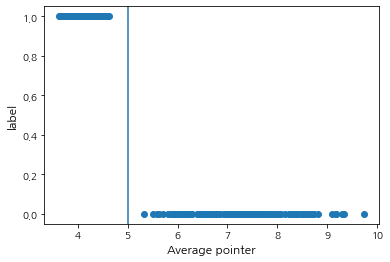

In [12]:
plt.scatter(data['Average pointer'], data['label'])
plt.axline((5,0), (5,1))
plt.xlabel('Average pointer', fontsize=12)
plt.ylabel('label', fontsize=12)
plt.show()

## Unique values for each feature

In [35]:
for col in X_train.columns:
    print(col, pd.unique(X_train[col]).size)

SEM 1 SGPA 111
SEM 1 KT 5
SEM 2 SGPA 108
SEM 2 KT 4
SEM 3 SGPA 111
SEM 3 KT 6
SEM 4 SGPA 83
SEM 4 KT 4
SEM 5 SGPA 110
SEM 5 KT 2
SEM 6 SGPA 103
SEM 6 KT 2
SEM 7 SGPA 96
SEM 7 KT 1
SEM 8 SGPA 101
How many hours per week do you spend on writing assignments? 2
How many hours per week do you spend on studies? 2
How much time does it take for you to reach college? 3
How much would you consider as your average attendance throughout all the semesters so far? 5
Internet availability at home 2
If yes, what is your internet speed? 1
What is your preferred mode of transportation to reach college? 3
Can you sit a lecture for 2 hrs straight? 2
Do you do your submissions on time? 2
If there are 5 hrs of lectures per day, would you attend all? 2
If there are 5 hrs of practicals per day, would you attend all? 2
Have you enrolled for coaching classes? 2
Have you won or participated in any Non - Technical event? 2
How socially active are you? 2


## SGPA features

In [16]:
gpa = [i for i in X_train.columns if 'SGPA' in i]

In [191]:
for col in gpa:
    a = X_train[y_train==0][col]
    b = X_train[y_train==1][col]
    if levene(a, b)[1]>=0.05:
        print(col, ttest_ind(a, b, equal_var=True)[1], 'equal_var')
    else:
        print(col, ttest_ind(a, b, equal_var=False)[1])

SEM 1 SGPA nan
SEM 2 SGPA 6.102496979194958e-65
SEM 3 SGPA nan
SEM 4 SGPA 8.698482373278904e-72
SEM 5 SGPA 2.354013002765067e-72
SEM 6 SGPA 7.58387238067935e-78
SEM 7 SGPA 4.569606688611951e-72
SEM 8 SGPA 5.347116293215151e-72


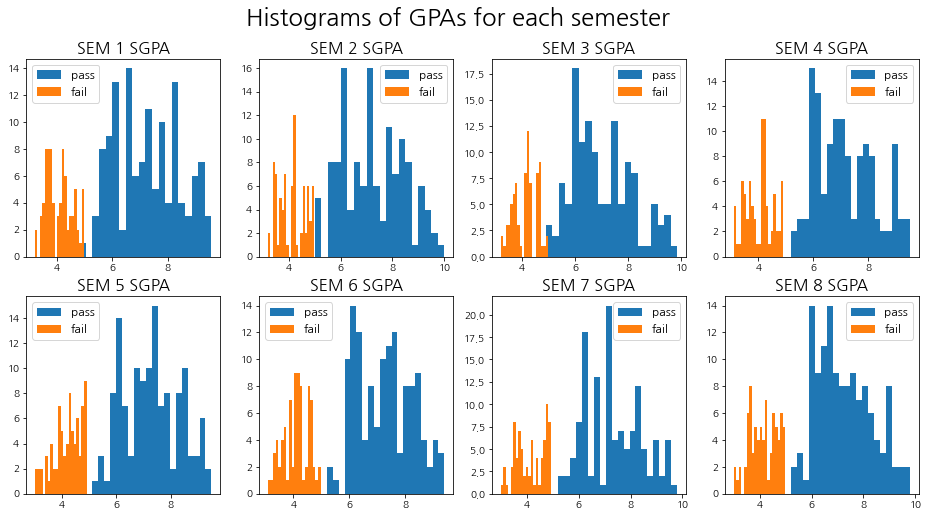

In [117]:
fig_feats = gpa

fig_n_col = 4
fig_n_idx = int(len(fig_feats)/fig_n_col) + 1*(lambda x: 1 if x>0 else 0)(len(fig_feats)%fig_n_col)
fig_scale = 4
    
fig = plt.figure(figsize=(fig_n_col*fig_scale, fig_n_idx*fig_scale))
for i in range(len(fig_feats)):
    ax = fig.add_subplot(int('{}{}{}'.format(fig_n_idx, fig_n_col,i+1)))
    ax.hist(X_train[y_train==0][fig_feats[i]], bins=20, label = 'pass')
    ax.hist(X_train[y_train==1][fig_feats[i]], bins=20, label = 'fail')
    ax.set_title(fig_feats[i], fontsize=16)
    plt.legend(fontsize=12)

plt.suptitle('Histograms of GPAs for each semester', fontsize=24, y=.97)
plt.show()

## KT features

In [17]:
kt = [i for i in X_train.columns if 'KT' in i]

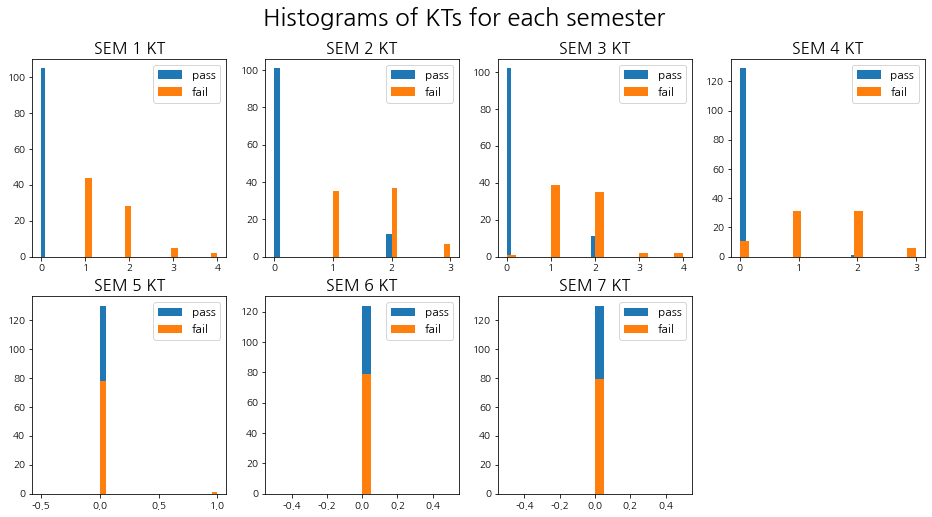

In [136]:
fig_feats = kt

fig_n_col = 4
fig_n_idx = int(len(fig_feats)/fig_n_col) + 1*(lambda x: 1 if x>0 else 0)(len(fig_feats)%fig_n_col)
fig_scale = 4
    
fig = plt.figure(figsize=(fig_n_col*fig_scale, fig_n_idx*fig_scale))
for i in range(len(fig_feats)):
    ax = fig.add_subplot(int('{}{}{}'.format(fig_n_idx, fig_n_col,i+1)))
    ax.hist(X_train[y_train==0][fig_feats[i]], bins=20, label = 'pass')
    ax.hist(X_train[y_train==1][fig_feats[i]], bins=20, label = 'fail')
    ax.set_title(fig_feats[i], fontsize=16)
    plt.legend(fontsize=12)

plt.suptitle('Histograms of KTs for each semester', fontsize=24, y=.97)
plt.show()

## Survey question features

In [18]:
surveys = set(X_train.columns) - set(gpa) - set(kt)
surveys = list(surveys)

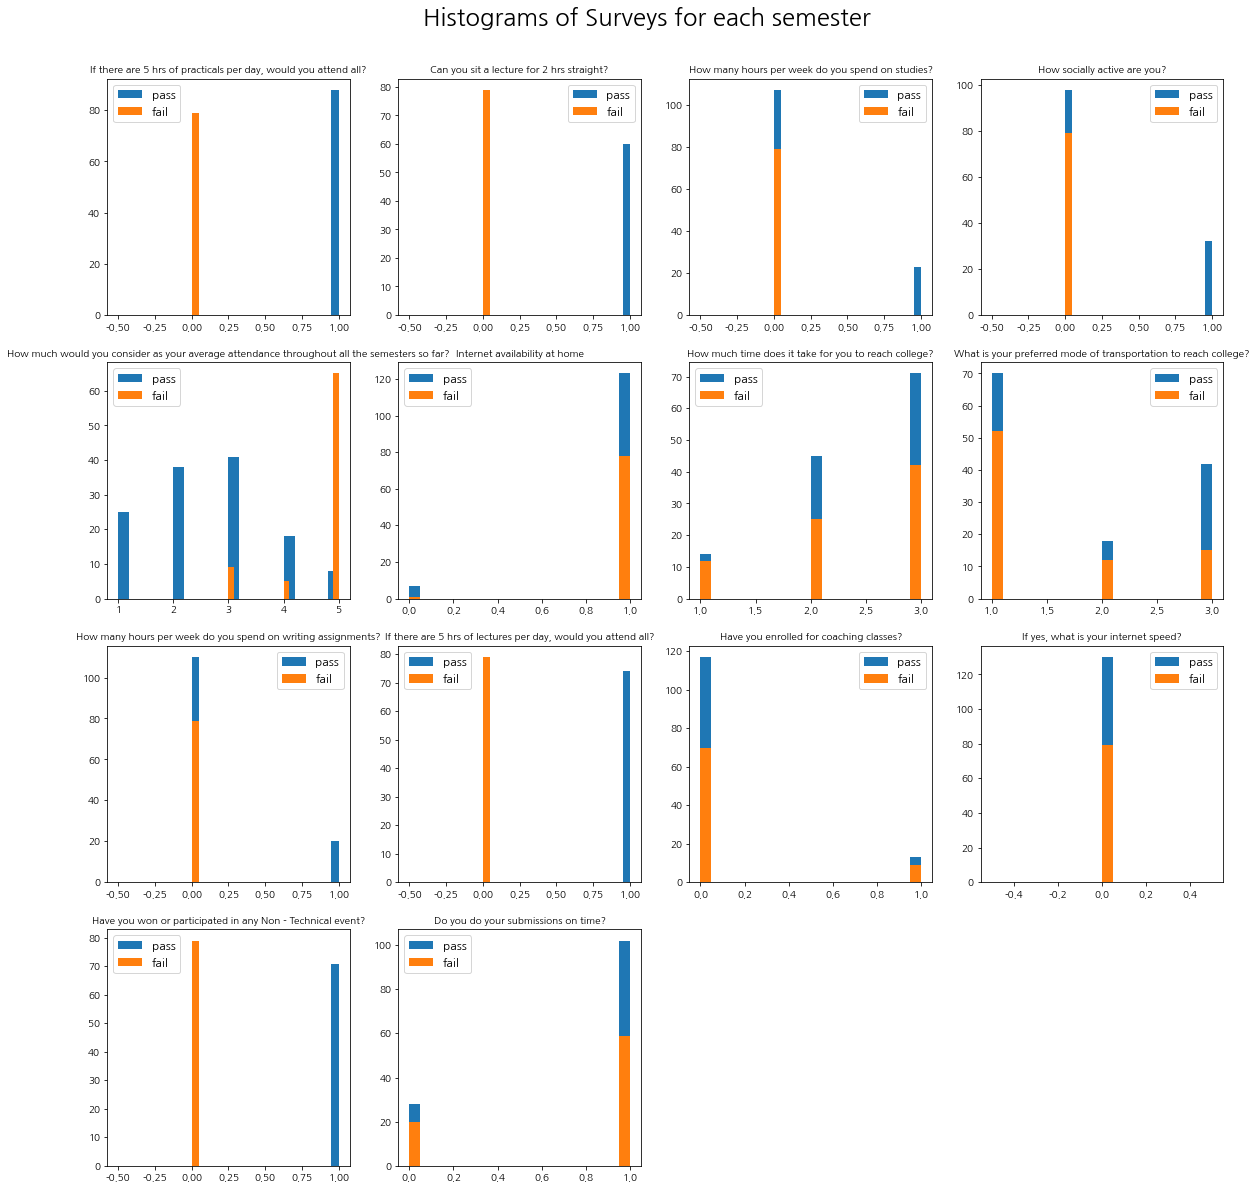

In [19]:
fig_feats = surveys

fig_n_col = 4
fig_n_idx = int(len(fig_feats)/fig_n_col) + 1*(lambda x: 1 if x>0 else 0)(len(fig_feats)%fig_n_col)
fig_scale = 5
    
fig = plt.figure(figsize=(fig_n_col*fig_scale, fig_n_idx*fig_scale))
for i in range(len(fig_feats)):
    ax = fig.add_subplot(fig_n_idx, fig_n_col,i+1)
    ax.hist(X_train[y_train==0][fig_feats[i]], bins=20, label = 'pass')
    ax.hist(X_train[y_train==1][fig_feats[i]], bins=20, label = 'fail')
    ax.set_title(fig_feats[i], fontsize=10)
    plt.legend(fontsize=12)

plt.suptitle('Histograms of Surveys for each semester', fontsize=24, y=.93)
plt.show()

## Missing values

* Missing values are observed only among **passed** students(label = 0)

In [13]:
X_train.isna().sum()[X_train.isna().sum()!=0]

SEM 1 SGPA    1
SEM 3 SGPA    1
SEM 3 KT      1
SEM 6 KT      6
dtype: int64

In [45]:
pd.crosstab(X_train[X_train['SEM 1 SGPA'].isna()==False]['SEM 1 SGPA'], columns=y_train[X_train['SEM 1 SGPA'].isna()==False]).sum(axis=0)

label
0    129
1     79
dtype: int64

In [44]:
pd.crosstab(X_train[X_train['SEM 3 SGPA'].isna()==False]['SEM 3 SGPA'], columns=y_train[X_train['SEM 3 SGPA'].isna()==False]).sum(axis=0)

label
0    129
1     79
dtype: int64

In [43]:
pd.crosstab(X_train[X_train['SEM 3 KT'].isna()==False]['SEM 3 KT'], columns=y_train[X_train['SEM 3 KT'].isna()==False]).sum(axis=0)

label
0    129
1     79
dtype: int64

In [143]:
pd.crosstab(X_train[X_train['SEM 6 KT'].isna()==False]['SEM 6 KT'], columns=y_train[X_train['SEM 6 KT'].isna()==False])

label,0,1
SEM 6 KT,,
0.0,124,79


# Feature Engineering

## Impute missing values

In [25]:
ki = KNNImputer()
X_train = ki.fit_transform(X_train)
X_test = ki.transform(X_test)

# Train

## Using all features w/ SEM < 5

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(str_cols.tolist()+['Label', 'Average pointer', 'label',
                                                                                'SEM 5 KT', 'SEM 6 KT', 'SEM 7 KT',
                                                                                'SEM 5 SGPA','SEM 6 SGPA','SEM 7 SGPA','SEM 8 SGPA',
                                                                                ], axis=1), data['label'], test_size=.2, random_state=42 )
feat_names = X_train.columns

ki = KNNImputer()
X_train = ki.fit_transform(X_train)
X_test = ki.transform(X_test)

In [30]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)
model.score(X_test, y_test)

1.0

In [27]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)
model.score(X_test, y_test)

1.0

In [28]:
pd.DataFrame(confusion_matrix(y_test, pred, labels=[1, 0]), index=['True 1', 'True 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
True 1,21,0
True 0,0,32


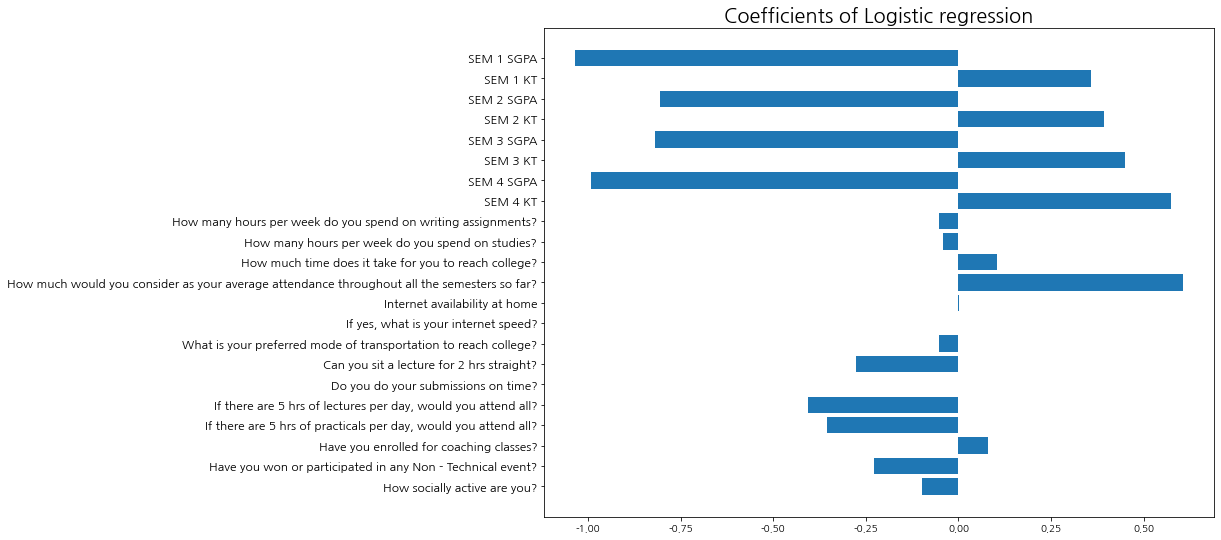

In [37]:
plt.figure(figsize=(12,9))
plt.barh(feat_names[::-1], model.coef_[0][::-1], )
plt.yticks(fontsize=12)
plt.title('Coefficients of Logistic regression', fontsize=20)
plt.show()

## Using survey question features only

In [38]:
model = LogisticRegression(random_state=42)
model.fit(X_train[:, np.where(np.isin(feat_names, surveys)==True)[0]], y_train)

pred = model.predict(X_test[:, np.where(np.isin(feat_names, surveys)==True)[0]],)
model.score(X_test[:, np.where(np.isin(feat_names, surveys)==True)[0]], y_test)

0.9811320754716981

In [39]:
pd.DataFrame(confusion_matrix(y_test, pred, labels=[1, 0]), index=['True 1', 'True 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
True 1,21,0
True 0,1,31
